# Tutorial

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from doom_arena import VizdoomMPEnv

from doom_arena.player import ObsBuffer

In [67]:
env = VizdoomMPEnv(
    num_players=1,
    num_bots=16,
    doom_map="map03",
    extra_state=[ObsBuffer.LABELS],
    episode_timeout=500,
)

Host 37275
Player 37275




In [68]:
env.enable_replay()

In [69]:
env.action_space

Discrete(6)

## Random policy (2 players)

In [70]:
for episode in range(1):
    ep_return = {k: 0.0 for k in range(env.num_players)}
    ep_step = 0
    obs = env.reset()
    done = None
    for _ in range(100):
        act = env.action_space.sample()
        obs, rwd, done, info = env.step(act)
        ep_return = {k: ep_return[k] + rwd[i] for i, k in enumerate(ep_return)}
        if done:
            print("ep steps: {}; ep return: {}".format(ep_step, ep_return))
            break
        else:
            ep_step += 1

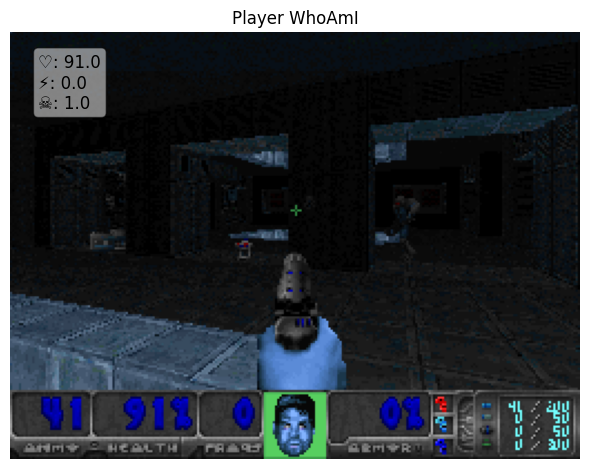

In [71]:
from IPython.display import HTML

from doom_arena.render import render_episode


ani = render_episode(env.get_player_replays())
HTML(ani.to_html5_video())

## Eval DQN

In [37]:
import numpy as np
import torch
from torch.nn import functional as F
from torchvision import transforms


def stack_dict(x):
    return np.concat(list(x.values()), 0)


def to_tensor(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return x


def resize(x):
    return F.interpolate(x.unsqueeze(0), (128, 128))


def minmax(x):
    # channelwise minmax (preserves different buffers as well)
    x_max = x.view(x.shape[0], x.shape[1], -1).max(-1)[0][..., *[None] * (x.ndim - 2)]
    x = x / (x_max + 1e-8)
    return torch.nan_to_num(x)


frame_transform = transforms.Compose([stack_dict, to_tensor, resize, minmax])

In [ ]:
from doom_arena import VizdoomMPEnv
from doom_arena.player import ObsBuffer


env = VizdoomMPEnv(
    num_players=1,
    num_bots=4,
    doom_map="map01",
    extra_state=[ObsBuffer.LABELS],
    episode_timeout=1000,
    player_transform=frame_transform,
)

env.enable_replay()

In [39]:
device = "cuda"

In [ ]:
from agents.dqn import DQN


dqn = DQN(
    input_dim=env.observation_space.shape[0],
    action_space=env.action_space.n,
    dim=64,
).to(device)

dqn.load_state_dict(torch.load("dqn.pth"))

In [ ]:
ep_return = {k: 0.0 for k in range(env.num_players)}
ep_step = 0
done = False
obs = env.reset()
while not done:
    obs = obs[0].to(device)
    act = dqn(obs).argmax().item()
    obs, rwd, done, info = env.step(act)
    ep_return = {k: ep_return[k] + rwd[i] for i, k in enumerate(ep_return)}
    if done:
        print("ep steps: {}; ep return: {}".format(ep_step, ep_return))
        break
    else:
        ep_step += 1

In [ ]:
from IPython.display import HTML

from doom_arena.render import render_episode


ani = render_episode(env.get_player_replays(), subsample=5)
HTML(ani.to_html5_video())